<a href="https://colab.research.google.com/github/ognjen217/DataForIEWDetectionTraining/blob/main/InlandExcessWaterDetectionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Loading required libraries and functions
import os
from PIL import Image
import pyproj
import os
import json
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from osgeo import gdal
import numpy as np
from PIL import Image

def normalize(array):
    min_val = array.min()
    max_val = array.max()
    return (array - min_val) / (max_val - min_val)

def save_png_with_packed_data_layers(tiff_file, output_png):
    # Open the georeferenced TIFF file
    dataset = gdal.Open(tiff_file)

    # Read the pixel values and extract the six bands
    bands = [dataset.GetRasterBand(i+1).ReadAsArray().astype(np.float32) for i in range(6)]

    # Normalize the values of each band
    normalized_bands = [normalize(band) for band in bands]

    # Stack all bands into a single array
    packed_data_layers = np.stack(normalized_bands, axis=-1)

    # Create a new RGBA image
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    rgba_image = np.zeros((height, width, 4), dtype=np.uint8)

    # Assign RGB channels with normalized values
    for i in range(3):
        rgba_image[:,:,i] = (normalized_bands[i] * 255).astype(np.uint8)

    # Pack the remaining three bands into the alpha channel
    rgba_image[:,:,3] = (packed_data_layers[:,:,3:].mean(axis=-1) * 255).astype(np.uint8)

    # Get the DPI information from the input TIFF file
    dpi_x = dataset.GetGeoTransform()[1]
    dpi_y = abs(dataset.GetGeoTransform()[5])  # assuming negative value indicates flipped Y axis

    # Save the PNG image with DPI information
    png_image = Image.fromarray(rgba_image, 'RGBA')
    png_image.save(output_png, dpi=(dpi_x, dpi_y))

    print(f"PNG image saved successfully: {output_png}")


def process_tiff_files(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over TIFF files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".tiff") or filename.endswith(".tif"):
            tiff_file = os.path.join(input_folder, filename)
            output_png = os.path.join(output_folder, os.path.splitext(filename)[0] + ".png")
            save_png_with_packed_data_layers(tiff_file, output_png)



In [ ]:
"""# Usage IEW
input_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri_preprocessed/iew/tiffs"
output_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri_preprocessed/iew/pngs"
process_tiff_files(input_folder, output_folder)
"""
# Usage for NOIEW
input_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri_preprocessed/no_iew"
output_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri_preprocessed/no_iew/pngs"
process_tiff_files(input_folder, output_folder)


In [ ]:
import os

def empty_folder(folder):
    # Iterate over the files in the folder and delete them
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")

# Usage
folder_to_empty = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/iew/pngs"
empty_folder(folder_to_empty)


In [8]:
import os
import random
import shutil

def split_dataset(input_folder, output_train_folder, output_valid_folder, output_test_folder, split_ratios=(0.7, 0.2, 0.1), seed=None):
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)

    # Create output folders if they don't exist
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_valid_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    # Get a list of all files in the input folder
    all_files = [file for file in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, file))]

    # Shuffle the list of files
    random.shuffle(all_files)

    # Calculate split indices
    train_split = int(len(all_files) * split_ratios[0])
    valid_split = train_split + int(len(all_files) * split_ratios[1])

    # Split the files into training, validation, and test sets
    train_files = all_files[:train_split]
    valid_files = all_files[train_split:valid_split]
    test_files = all_files[valid_split:]

    # Move files to the respective output folders
    for file in train_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_train_folder, file))

    for file in valid_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_valid_folder, file))

    for file in test_files:
        shutil.move(os.path.join(input_folder, file), os.path.join(output_test_folder, file))

# Example usage:
input_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri_preprocessed/iew/pngs"
output_train_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/TrainingSet/IEW"
output_valid_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/ValidationSet/IEW"
output_test_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/TestSet/IEW"
split_ratios = (0.7, 0.2, 0.1)  # 70% training, 20% validation, 10% test
split_dataset(input_folder, output_train_folder, output_valid_folder, output_test_folder, split_ratios, seed=42)

input_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri_preprocessed/no_iew/pngs"
output_train_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/TrainingSet/NIEW"
output_valid_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/ValidationSet/NIEW"
output_test_folder = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/TestSet/NIEW"
split_ratios = (0.7, 0.2, 0.1)  # 70% training, 20% validation, 10% test
split_dataset(input_folder, output_train_folder, output_valid_folder, output_test_folder, split_ratios, seed=42)



In [9]:
# Loading data and preprocessing images according to mobilenet requirements
# Creating batches of data

############## POTREBNO JE SREDITI ULAZE I UPLADOVATI IH NA CLOUD/GIT

labels = ['IEW', 'NIEW']
train_path = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/TrainingSet"
valid_path = "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/ValidationSet"
test_path =  "/content/drive/MyDrive/dataForTraining/awei_ndmi_mndwi_msavi2_ndre_wri/TestSet"

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10)

Found 1478 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 227 images belonging to 2 classes.


In [10]:
#Loading pre-trained lightweight mobilenet image classifier
mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False)
#mobile.summary()

17225924/17225924 [==============================] - 0s 0us/step


In [11]:
# Store all layers of the original mobilenet except the last 5 layers in variable x
# There is no predefined logic behind this, it just gives the optimal results for this task
# Also, we will be only training the last 12 layers of the mobilenet during finetuning as we want
# it to keep all of the previously learned weights
x = mobile.layers[-12].output
x

<KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'conv_dw_12')>

In [12]:
# Create global pooling, dropout and a binary output layer, as we want our model to be a binary classifier,
# i.e. to classify flooding and no flooding
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
output = Dense(units=2, activation='sigmoid')(x)

In [13]:
# Construct the new fine-tuned mode
model = Model(inputs=mobile.input, outputs=output)

In [14]:
# Freez weights of all the layers except for the last five layers in our new model,
# meaning that only the last 12 layers of the model will be trained.
for layer in model.layers[:-23]:
    layer.trainable = False

In [15]:
# This code adds new structure for input layer
# And copies structure of pretrained network so it is usable in future, but for different input (depth is 6)

x = tf.keras.Input(shape=(None, None, 6))
l = model.layers[1](x)  # layer 0 is the input layer, which we're replacing
for i in range(2, len(model.layers)):
    l = model.layers[i](l)

stacked_model = tf.keras.Model(x,l)



In [16]:
# Compile the model
stacked_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
stacked_model.summary()

In [28]:
stacked_model.fit(
    x=train_batches,
    steps_per_epoch = len(train_batches),
    validation_data = valid_batches,
    validation_steps = len(valid_batches),
    epochs = 5,
    verbose = 1,
    class_weight = {0 : 100.,
                    1: 1.}
)

Epoch 1/5
148/148 [==============================] - 102s 692ms/step - loss: 0.0741 - accuracy: 0.9844 - val_loss: 0.3758 - val_accuracy: 0.9548
Epoch 2/5
148/148 [==============================] - 95s 639ms/step - loss: 0.0641 - accuracy: 0.9844 - val_loss: 0.1058 - val_accuracy: 0.9796
Epoch 3/5
148/148 [==============================] - 92s 617ms/step - loss: 0.4913 - accuracy: 0.9594 - val_loss: 0.3073 - val_accuracy: 0.9344
Epoch 4/5
148/148 [==============================] - 94s 638ms/step - loss: 0.1620 - accuracy: 0.9682 - val_loss: 0.1405 - val_accuracy: 0.9661
Epoch 5/5
148/148 [==============================] - 99s 668ms/step - loss: 0.0502 - accuracy: 0.9885 - val_loss: 0.1236 - val_accuracy: 0.9683


In [39]:
# Saving and loading our trained for future use

stacked_model.save("awei_ndmi_mndwi_msavi2_ndre_wri_1.keras")
stacked_model.load_weights('awei_ndmi_mndwi_msavi2_ndre_wri_1.keras')

In [ ]:
model = keras.saving.load_model("/content/drive/MyDrive/awei_ndmi_mndwi_msavi2_ndre_wri_1.keras", custom_objects=None, compile=True, safe_mode=True)

23/23 [==============================] - 7s 299ms/step
Precision:  0.4782608695652174
F1 Score:  0.4680851063829787
Accuracy:  0.44933920704845814


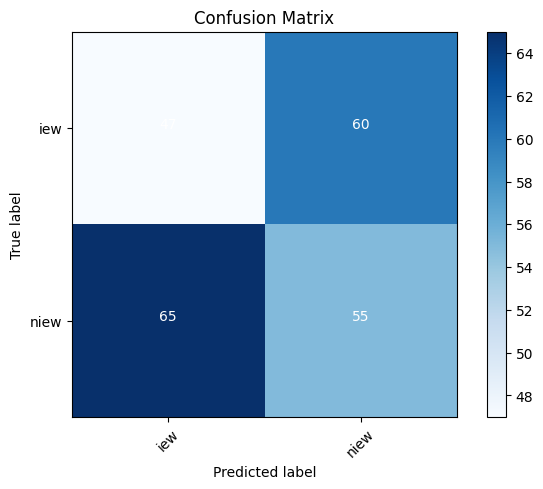

In [29]:
# Make predictions and plot confusion matrix to look how well our model performed in classifying
from sklearn.metrics import confusion_matrix, precision_score, f1_score, accuracy_score
test_labels = test_batches.classes
predictions = stacked_model.predict(x=test_batches, steps=len(test_batches), verbose=1)

cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))  # Rename variable
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion Matrix
test_batches.class_indices
cm_plot_labels = ['iew','niew']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Pring precision, F1 score and accuracy of our model
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

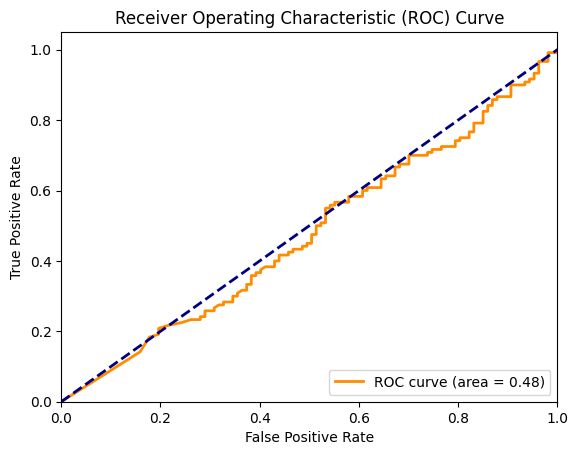

In [20]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])  # Assuming the positive class is index 1
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()